## Import Requirement Library

In [1]:
import os
import tensorflow as tf


print('Using TensorFlow Version:', tf.__version__)

Using TensorFlow Version: 2.17.0


## Download and Prepare

In [2]:
# clean /content
!rm -rf /content/*

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Upload Github deploy-key

Kode ini digunakan untuk mengupload deploy key pada github menggunakan Google Colab. Deploy key mendapatkan dataset private di github

In [4]:
from google.colab import files

# Upload deploykey
print("Upload your SSH private key\n")
uploaded = files.upload()

# Membuat folder .ssh jika tidak tersedia
if not os.path.exists('/root/.ssh'):
    os.makedirs('/root/.ssh')

# Menyalin file yang di-upload ke /root/.ssh/
for file_name in uploaded.keys():
    destination_file = '/root/.ssh/id_rsa'

    # Menyalin file yang di-upload ke file tujuan
    with open(destination_file, 'wb') as f:
        f.write(uploaded[file_name])

    # Mengatur permission file
    os.chmod(destination_file, 0o600)


# Menambahkan github.com ke dalam known_hosts
!ssh-keyscan -t rsa github.com > /root/.ssh/known_hosts

Upload your SSH private key



Saving deploykey to deploykey
# github.com:22 SSH-2.0-babeld-29dce086b


In [5]:
!git clone git@github.com:adeiskandarzulkarnaen/dataset-aksarasunda.git
#!rm dataset-aksarasunda/readme.md

Cloning into 'dataset-aksarasunda'...
remote: Enumerating objects: 3776, done.
remote: Counting objects: 100% (3776/3776), done.
remote: Compressing objects: 100% (3743/3743), done.
remote: Total 3776 (delta 31), reused 3775 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (3776/3776), 18.69 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [6]:
!git clone https://github.com/ridhomujizat/AksaraSundaCNN.git

!cp -r /content/AksaraSundaCNN/train/* /content/dataset-aksarasunda/training/
!cp -r /content/AksaraSundaCNN/test/* /content/dataset-aksarasunda/validation/

Cloning into 'AksaraSundaCNN'...
remote: Enumerating objects: 5780, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 5780 (delta 3), reused 0 (delta 0), pack-reused 5767 (from 1)
Receiving objects: 100% (5780/5780), 145.21 MiB | 17.24 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Updating files: 100% (11371/11371), done.


## Creating the ImageGenerators for the CNN

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Setting up image generator for train data
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     fill_mode='nearest')

  # Automatically label training data based on folders
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=16,
      class_mode='sparse',
      target_size=(224, 224)
  )

  # Setting up image generator for data validation
  validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

  # Automatically label based on folder in data validation
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=16,
      class_mode='sparse',
      target_size=(224, 224)
  )

  return train_generator, validation_generator

In [14]:
TRAINING_DIR   = "/content/dataset-aksarasunda/training/"
VALIDATION_DIR = "/content/dataset-aksarasunda/validation/"

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 7296 images belonging to 30 classes.
Found 1788 images belonging to 30 classes.


## Build Model

In [15]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  # Define the correct function signature for on_epoch_end
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.97:
      print("\nReached 97% accBuracy so cancelling training!")
      # Stop training once the above condition is met
      self.model.stop_training = True

In [16]:

def create_model():
    # Load the VGG16 model without the fully connected layer
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    # Add a new fully connected layer
    x = base_model.output

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(30, activation='softmax')(x)


    # Create a new model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

    # Freeze all convolution layers of VGG16
    for layer in base_model.layers:
        layer.trainable = False


    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## Model Sumary

In [17]:
# Get the untrained model
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │              

 Total params: 14,992,734 (57.19 MB)

 Trainable params: 278,046 (1.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Train Model

In [18]:
# Train the model, this may take some time.
accuracy_callback = AccuracyCallback()

history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[accuracy_callback])

Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 131s 263ms/step - accuracy: 0.1654 - loss: 2.9638 - val_accuracy: 0.7209 - val_loss: 1.3046
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 108s 234ms/step - accuracy: 0.5527 - loss: 1.6040 - val_accuracy: 0.8490 - val_loss: 0.6648
Epoch 3/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 108s 231ms/step - accuracy: 0.6947 - loss: 1.0455 - val_accuracy: 0.9133 - val_loss: 0.4186
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/step - accuracy: 0.7573 - loss: 0.8215 - val_accuracy: 0.8887 - val_loss: 0.3753
Epoch 5/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 139s 230ms/step - accuracy: 0.7938 - loss: 0.6985 - val_accuracy: 0.9346 - val_loss: 0.2682
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.8107 - loss: 0.6013 - val_accuracy: 0.9251 - val_loss: 0.2473
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 106s 228ms/step - accuracy: 0.8199 - loss: 0.5576 - val_accuracy: 0.9413 - val_loss: 0.2114
Epoch 8/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 141s 229ms/step - accuracy: 0.8528 -

## Plot History

In [19]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ["accuracy", "loss"]
    plt.figure(figsize=(16, 10))

    for n, metric in enumerate(metrics):
        # Change metric name format to uppercase
        name = metric.replace("_", " ").capitalize()

        # Plot training and validation metrics
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch,
                 history.history[metric],
                 label='Training')
        plt.plot(history.epoch,
                 history.history['val_'+metric],
                 linestyle="--",
                 label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(True)

        # Set the y-axis limits for better visualization.
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])

        plt.legend()

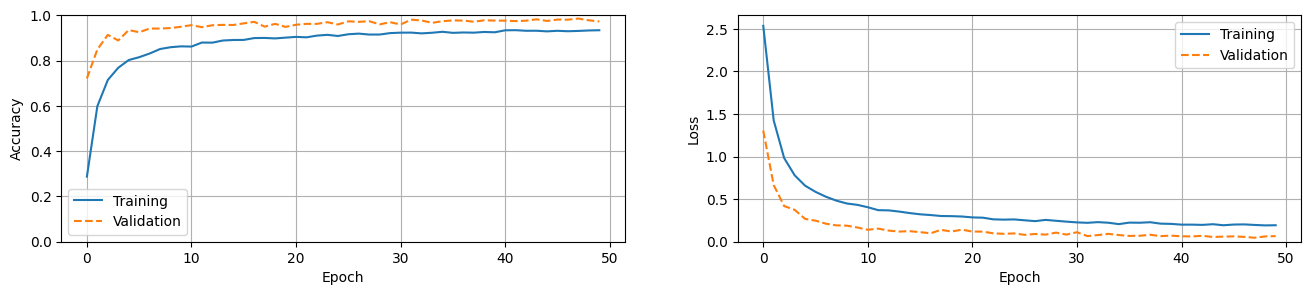

In [20]:
plot_metrics(history)

## Generate Report

112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step


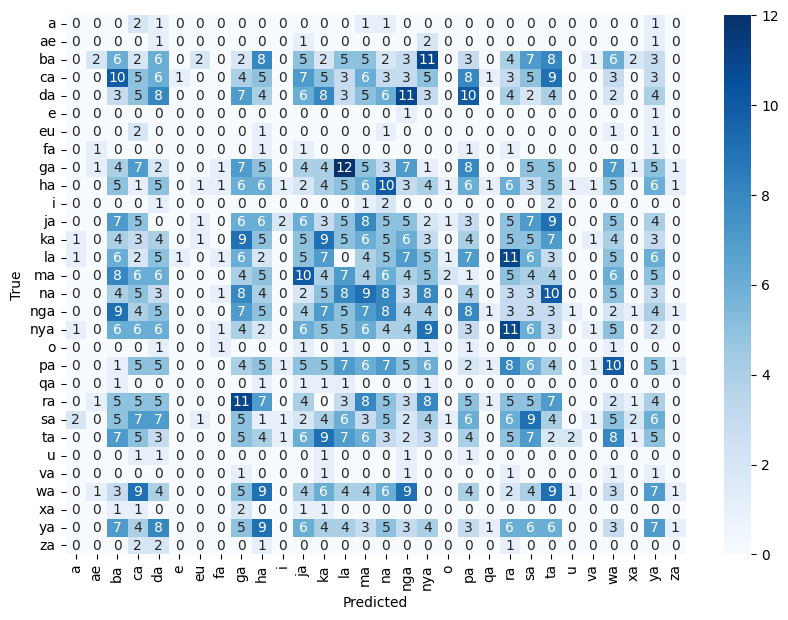

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Melakukan prediksi pada data validasi
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label asli dari data validasi (sudah dalam bentuk integer)
y_true = validation_generator.classes

# Mendapatkan nama kelas
target_names = list(validation_generator.class_indices.keys())

# Membuat laporan klasifikasi
# report = classification_report(y_true, y_pred_classes, target_names=target_names)
# print("Classification Report:\n", report)


# Membuat Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) # Menghitung confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Save Model
mengimpan model ke dalam format .h5. model ini nantinya bisa di load jika mau digunakan lagi.

### Save to .h5 file

In [24]:
# from google.colab import drive
drive.mount('/content/drive')

# Setelah melatih model
model.save('nusanl_sunda.h5')

# Memindahkan file hasil training ke Google Drive
!cp nusanl_sunda.h5 /content/drive/MyDrive/nusanl_sunda.h5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save model to TFLite

In [25]:
# Load model h5
# model = tf.keras.models.load_model(filepath="nusanl_sunda.h5")

# Convert model h5
konversi = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = konversi.convert()

#Simpan model yang sudah diconvert
with tf.io.gfile.GFile('nusanl_sunda.tflite', 'wb') as f:
  f.write(model_tflite)

Saved artifact at '/tmp/tmpm2lpvar2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  134263767549728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767552368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767548320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767556064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767557648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767559936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767560288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767562576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767562928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134263767563632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13426336

### Save History

In [26]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  # files.download('history.pkl')

download_history()

## Test

In [ ]:
# Load model h5
model = tf.keras.models.load_model(filepath="nusanl_sunda.h5")


## Manual Testing

Melakukan testing dengan menguplod gambar untuk mengecek kesesuaian model.

Saving ca.png to ca.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


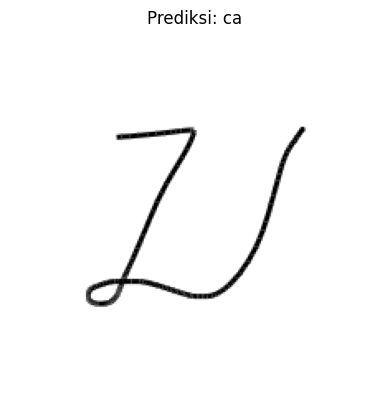

In [27]:
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array


# Ambil class names dari training_generator
class_names = list(train_generator.class_indices.keys())


uploaded = files.upload()
for path in uploaded.keys():
    img = load_img(path, target_size=(224, 224))        # Membaca gambar
    img_array = img_to_array(img)                       # Mengubah gambar menjadi array numpy
    img_array = np.expand_dims(img_array, axis=0)       # Menambah dimensi ke-4 untuk sesuaikan dengan input model
    images = np.vstack([img_array])


    prediction = model.predict(images, batch_size=10)   # Melakukan prediksi
    result = class_names[np.argmax(prediction)]


    # Menampilkan gambar dan text hasil prediksi
    plt.imshow(img); plt.axis('off')
    plt.title(f'Prediksi: {result}')
    plt.show()

In [32]:
# print(list(train_generator.class_indices.keys()))

# Simpan ke dalam file label.txt
with open('lable_nusanl_sunda.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


In [34]:
# Baca dan cetak isi file untuk verifikasi
with open('lable_nusanl_sunda.txt', 'r') as f:
    print(f.read())

a
ae 
ba
ca
da
e
eu
fa
ga
ha
i
ja
ka
la
ma
na
nga
nya
o
pa
qa
ra
sa
ta
u
va
wa
xa
ya
za

